In [50]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from scipy import linalg
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [51]:
!pip install -U --no-cache-dir gdown --pre
!gdown https://drive.google.com/uc?id=1-HQ8KiKdbDX6qEwCUZur0W0_5u6GKYgA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1-HQ8KiKdbDX6qEwCUZur0W0_5u6GKYgA
To: /content/drive/.shortcut-targets-by-id/1VsUPkrgImImc_F-D3nszvydxOV9vJ1Co/Maps/HumanChr5.csv
100% 535M/535M [00:04<00:00, 130MB/s]


In [52]:
data = np.genfromtxt('HumanChr5.csv', delimiter=',')
data.shape

(4844, 4844)

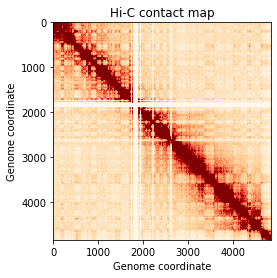

In [35]:
plt.imshow(data, vmin=0, vmax=0.00015, cmap='OrRd')
plt.xlabel('Genome coordinate')
plt.ylabel('Genome coordinate')
plt.title('Hi-C contact map')
plt.show()
# Note, in centromere region of chromosome Hi-C method is not working
# Thus, there NaNs there (~1800th coordinate) 

In [15]:
data[np.isnan(data)] = 0 # zero NaNs

n = len(data)

# Creation of Toeplitz matrix of expected contact map - averaging across all diagonals
col = np.zeros(n)
for i in range(n):
  col[i] = np.diag(data, i).mean()

expected = linalg.toeplitz(col, col)
observed = data.copy()

res = data.copy()
res[res != 0] = observed[res != 0] / expected[res != 0] # resulting matrix is normalized over expected contact map

Text(0.5, 1.0, 'Observed/expected')

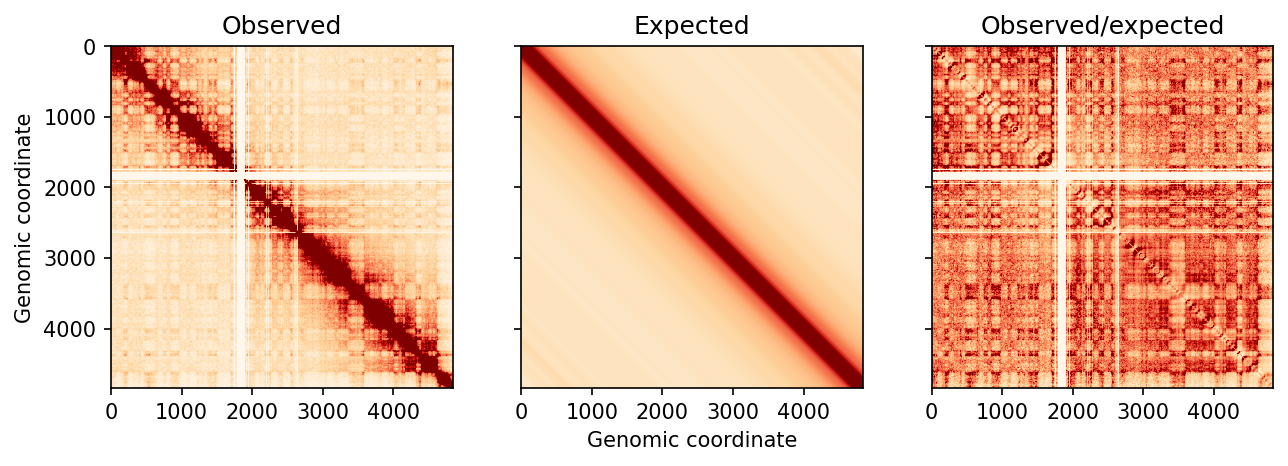

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=150, figsize=(10, 5), sharex=True, sharey=True)

axes[0].imshow(observed, vmin=0, vmax=0.00015, cmap='OrRd')
axes[0].set_title('Observed')
axes[0].set_ylabel('Genomic coordinate')

axes[1].imshow(expected, vmin=0, vmax=0.00015, cmap='OrRd')
axes[1].set_title('Expected')
axes[1].set_xlabel('Genomic coordinate')

axes[2].imshow(res, vmin=0, vmax=2, cmap='OrRd')
axes[2].set_title('Observed/expected')

In [37]:
to_drop = np.where((res != 0).sum(axis=0) == 0)[0] # rows/cols filled with zeros from NaNs - we eliminate them to get more accurate eigenvalue

In [44]:
dropped_res = np.delete(res, to_drop, axis=0)
dropped_res = np.delete(dropped_res, to_drop, axis=1)
eigs = np.linalg.eig(dropped_res-1) # -1 is heuristic to get eigenvalues changing its sign.
# Note that without -1 distribution ov res entries starts from 0 and does not contain negative values. 

In [40]:
first = eigs[1][:, 0]
for i in to_drop:
  first = np.insert(first, i, np.nan) # adding NaNs back

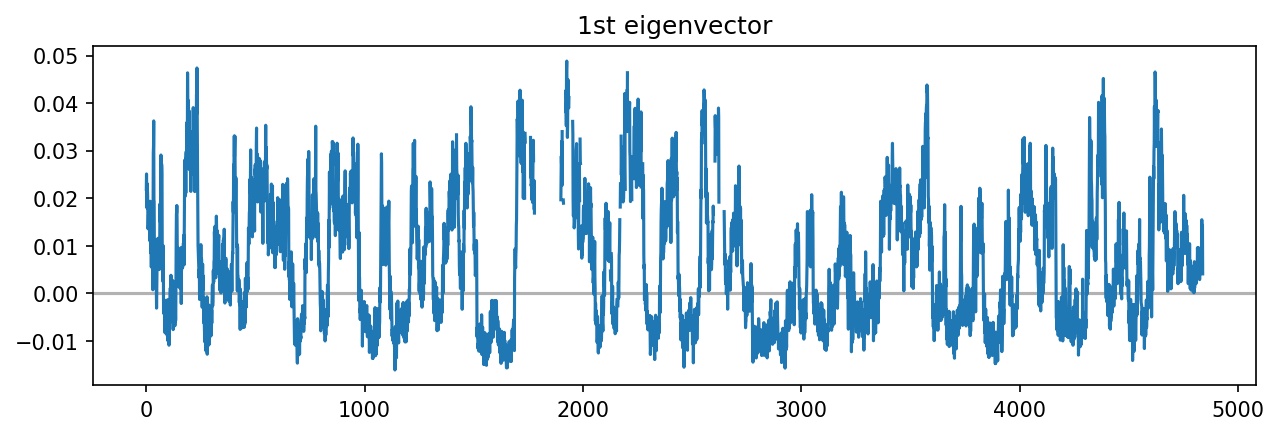

In [48]:
plt.figure(dpi=150, figsize=(10, 3))
plt.axhline(0, c='tab:gray', alpha=0.6)
plt.plot(first)
plt.title('1st eigenvector')
plt.show()

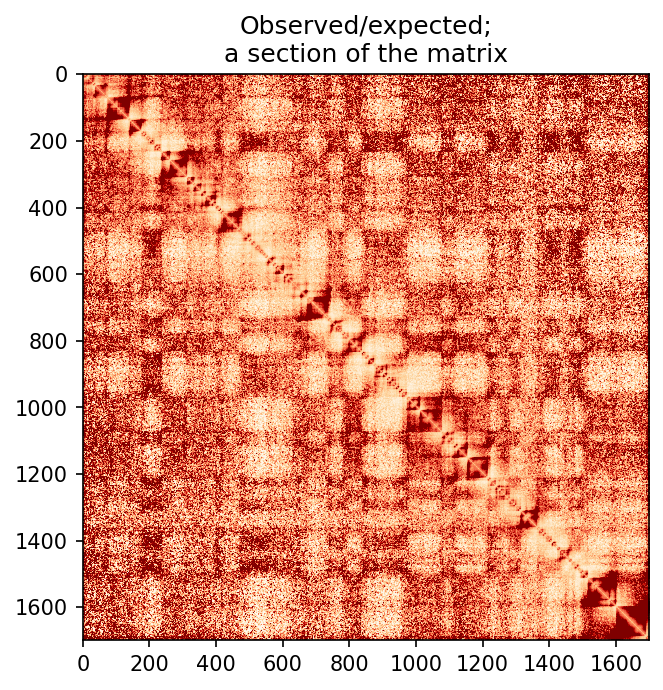

In [49]:
max_ = 1700

plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(res[:max_, :max_], vmin=0, vmax=2, cmap='OrRd')
plt.title('Observed/expected;\na section of the matrix')
plt.show()

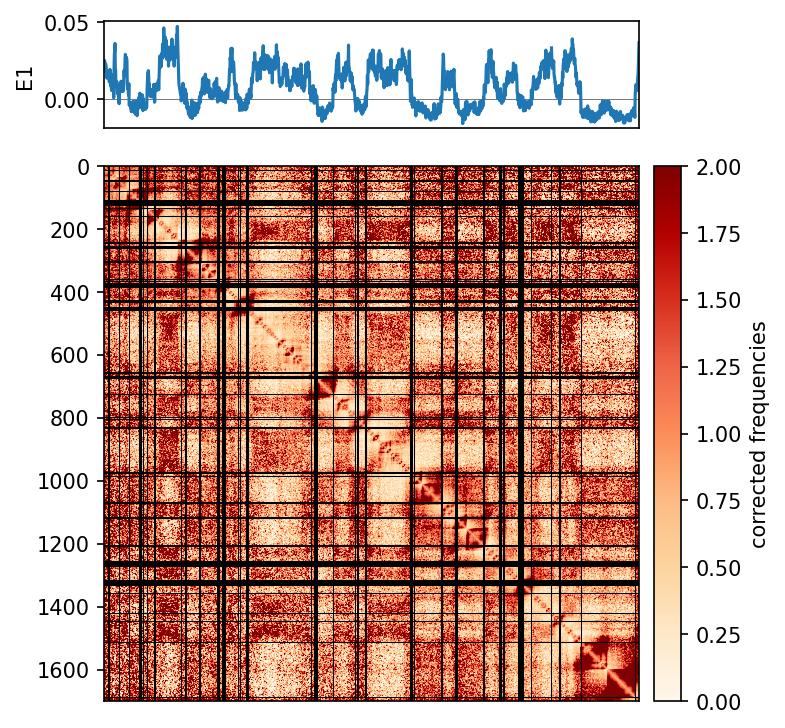

In [43]:
f, ax = plt.subplots(
    dpi=150,
    figsize=(10, 6),
)

im = ax.imshow(
    res[:max_, :max_], 
    vmin=0, vmax=2,
    cmap='OrRd'
); 
plt.axis([0,max_,max_,0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
weights = res
ax1.plot([0,max_],[0,0],'k',lw=0.25)
ax1.plot(first[:max_], label='E1')

ax1.set_ylabel('E1')
ax1.set_xticks([]);

for i in np.where(np.diff(first[:max_]>0).astype(int))[0]:
    ax.plot([0, max_],[i,i],'k',lw=0.5)
    ax.plot([i,i],[0, max_],'k',lw=0.5)